# Laboratory Demo
This notebook walks through the main features of `Laboratory`: configuration, process visualisation, sampling, running experiments and finding the optimum — first without noise, then with noise added.

In [1]:
import sys
from pathlib import Path

# Notebook lives inside msbo/; add the project root (one level up) to sys.path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from msbo.simulator.laboratory import Laboratory
from msbo.simulator.utils import plot_1d, plot_2d

/home/luca/miniconda3/envs/tesi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Configuration

All keys accepted by `Laboratory` (and its internal `MultiStepProcess`):

| Key | Type | Description |
|---|---|---|
| `input_dim` | `dict[int, int]` | Number of free input parameters (`x`) per stage |
| `output_dim` | `dict[int, int]` | Hidden-state dimensionality (`h`) per stage |
| `measurement` | `dict[int, tuple]` | How `h` is turned into observable `m`; `('identity', None)` passes `h` through unchanged, `('filter', k)` keeps only the first `k` channels |
| `complexity` | `dict[int, int]` | Controls the size of the seed dataset used to initialize the NNs modeling each stage (higher = more complex function) |
| `noise_process` | `dict[int, float]` | Std of Gaussian noise added to `h` at each stage |
| `noise_meas` | `dict[int, float]` | Std of Gaussian noise added to the measurement `m` |
| `seed` | `int` | Random seed for reproducibility |

**Two-stage process used here:**
- Stage 0: 2D input → 2D hidden state
- Stage 1: no extra input, receives `h₀` (2D) → scalar output
- Total parameter space is 2D, so outputs can be plotted as surfaces.

In [2]:
# ── tweak any of these to experiment ──────────────────────────────────────────
SEED = 0
COMPLEXITY = {0: 16, 1: 4}   # number of neural-network prototype points per stage

config = {
    'input_dim':   {0: 2, 1: 0},          # stage 0 gets 2 free params; stage 1 gets none
    'output_dim':  {0: 2, 1: 1},          # stage 0 produces 2-D hidden state; stage 1 scalar
    'measurement': {0: ('identity', None), # m₀ = h₀  (full hidden state observed)
                    1: ('identity', None)},# m₁ = h₁  (scalar output observed)
    'complexity':  COMPLEXITY,
    'seed':        SEED,
}

lab = Laboratory(config)
print("Processes:", lab.process.n_processes)

Processes: [0, 1]


## 2. Visualise the Process
We build two thin wrappers that accept an `(N, 2)` input array and return scalars, then pass them directly to `plot_2d`.

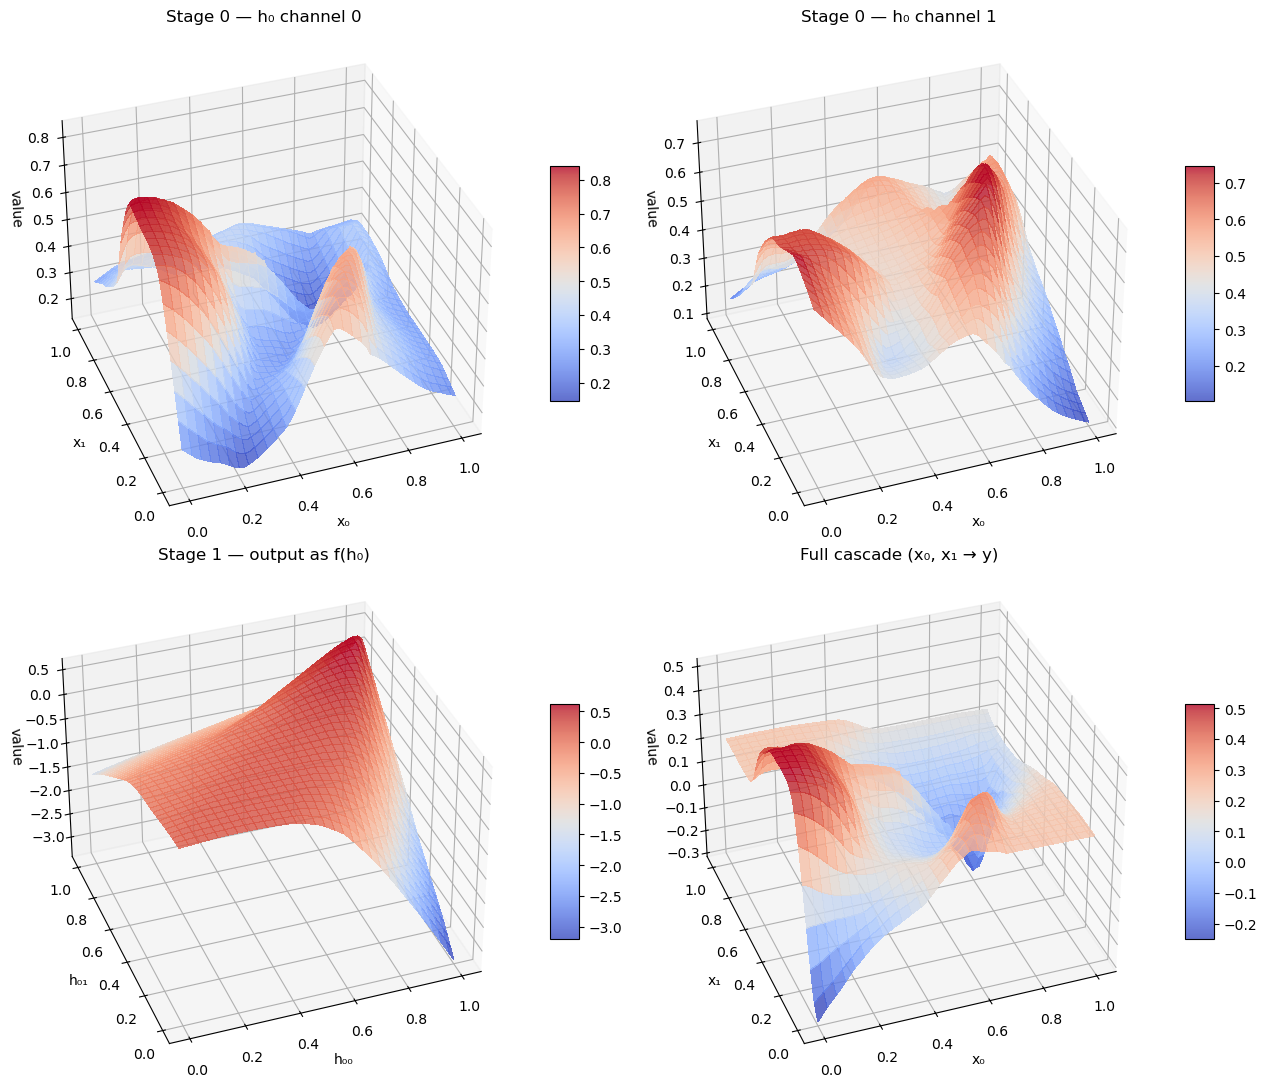

In [3]:
def stage0_ch0(X):
    """First channel of stage-0 hidden state as a function of (x0, x1)."""
    h, _ = lab.process.call_subprocess(x=X, h=None, idx=0)
    return h[:, :1]

def stage0_ch1(X):
    """Second channel of stage-0 hidden state as a function of (x0, x1)."""
    h, _ = lab.process.call_subprocess(x=X, h=None, idx=0)
    return h[:, 1:2]

def stage1_only(H):
    """Output of stage 1 as a function of h0."""
    # H is the h0 values (n, 2)
    n = H.shape[0]
    # Call stage 1 subprocess with h0 as input
    result, _ = lab.process.call_subprocess(x=np.empty((n, 0)), h=H, idx=1)
    return result

def final_output(X):
    """Scalar output of stage 1 as a function of (x0, x1)."""
    n = X.shape[0]
    data = {0: {'x': X}, 1: {'x': np.empty((n, 0))}}
    h_list, _ = lab.process(data)
    return h_list[-1]   # shape (N, 1)

fig, axes = plt.subplots(2, 2, figsize=(13, 11), subplot_kw={'projection': '3d'})
axes = axes.ravel()

a = np.linspace(0, 1, 60)
y_grid, x_grid = np.meshgrid(a, a)
X_grid = np.stack((x_grid, y_grid), axis=2).reshape(-1, 2)

plots = [
    (stage0_ch0, 'Stage 0 — h₀ channel 0', 'x₀', 'x₁'),
    (stage0_ch1, 'Stage 0 — h₀ channel 1', 'x₀', 'x₁'),
    (stage1_only, 'Stage 1 — output as f(h₀)', 'h₀₀', 'h₀₁'),
    (final_output, 'Full cascade (x₀, x₁ → y)', 'x₀', 'x₁'),
]

for ax, (fn, title, xlabel, ylabel) in zip(axes, plots):
    if 'stage1_only' in fn.__name__:
        # For stage 1, use h0 values as grid
        z = fn(X_grid).reshape(x_grid.shape)
    else:
        z = fn(X_grid).reshape(x_grid.shape)
    
    surf = ax.plot_surface(x_grid, y_grid, z, cmap='coolwarm', linewidth=0,
                           antialiased=False, alpha=0.8)
    ax.view_init(elev=35, azim=-110)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel('value')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.45, aspect=8)

plt.tight_layout()
plt.show()

## 3. Sobol Sampling
`randomized_sampling` draws quasi-random samples using a Sobol sequence, runs them through all process stages and stores the results in the inventory.

In [4]:
N_INIT = 5   # ← change this to sample more / fewer points

# Re-create lab so the inventory is empty before sampling
lab = Laboratory(config)

lab.randomized_sampling(n_samples=N_INIT, method='sobol')
print(f"Samples per stage: {lab.samples_per_process()}")
lab.inventory_table

Samples per stage: [5, 5]


process ID                         0  \
                                   x   
sample ID                              
0              [0.4751072, 0.592524]   
1           [0.57876337, 0.03712194]   
2              [0.9506699, 0.862344]   
3            [0.12045787, 0.2614422]   
4            [0.21494523, 0.9741822]   

process ID                                            \
                                                   h   
sample ID                                              
0           [0.5307425856590271, 0.4762621521949768]   
1           [0.6281765699386597, 0.5227713584899902]   
2           [0.3963409662246704, 0.5747478604316711]   
3            [0.7454543113708496, 0.685617983341217]   
4           [0.3645237684249878, 0.2685052156448364]   

process ID                                             1  \
                                                   m   x   
sample ID                                                  
0           [0.5307425856590271, 0.4762621521949768]  []   
1           [0.6281765699386597, 0.5227713584899902]  []   
2           [0.3963409662246704, 0.5747478604316711]  []   
3            [0.7454543113708496, 0.685617983341217]  []   
4           [0.3645237684249878, 0.2685052156448364]  []   

process ID                                                
                                h                      m  
sample ID                                                 
0           [0.24921725690364838]  [0.24921725690364838]  
1            [0.3153664767742157]   [0.3153664767742157]  
2           [0.06831255555152893]  [0.06831255555152893]  
3            [0.4471483528614044]   [0.4471483528614044]  
4           [0.22680924832820892]  [0.22680924832820892]

### Overlay sampled points on the final-output surface

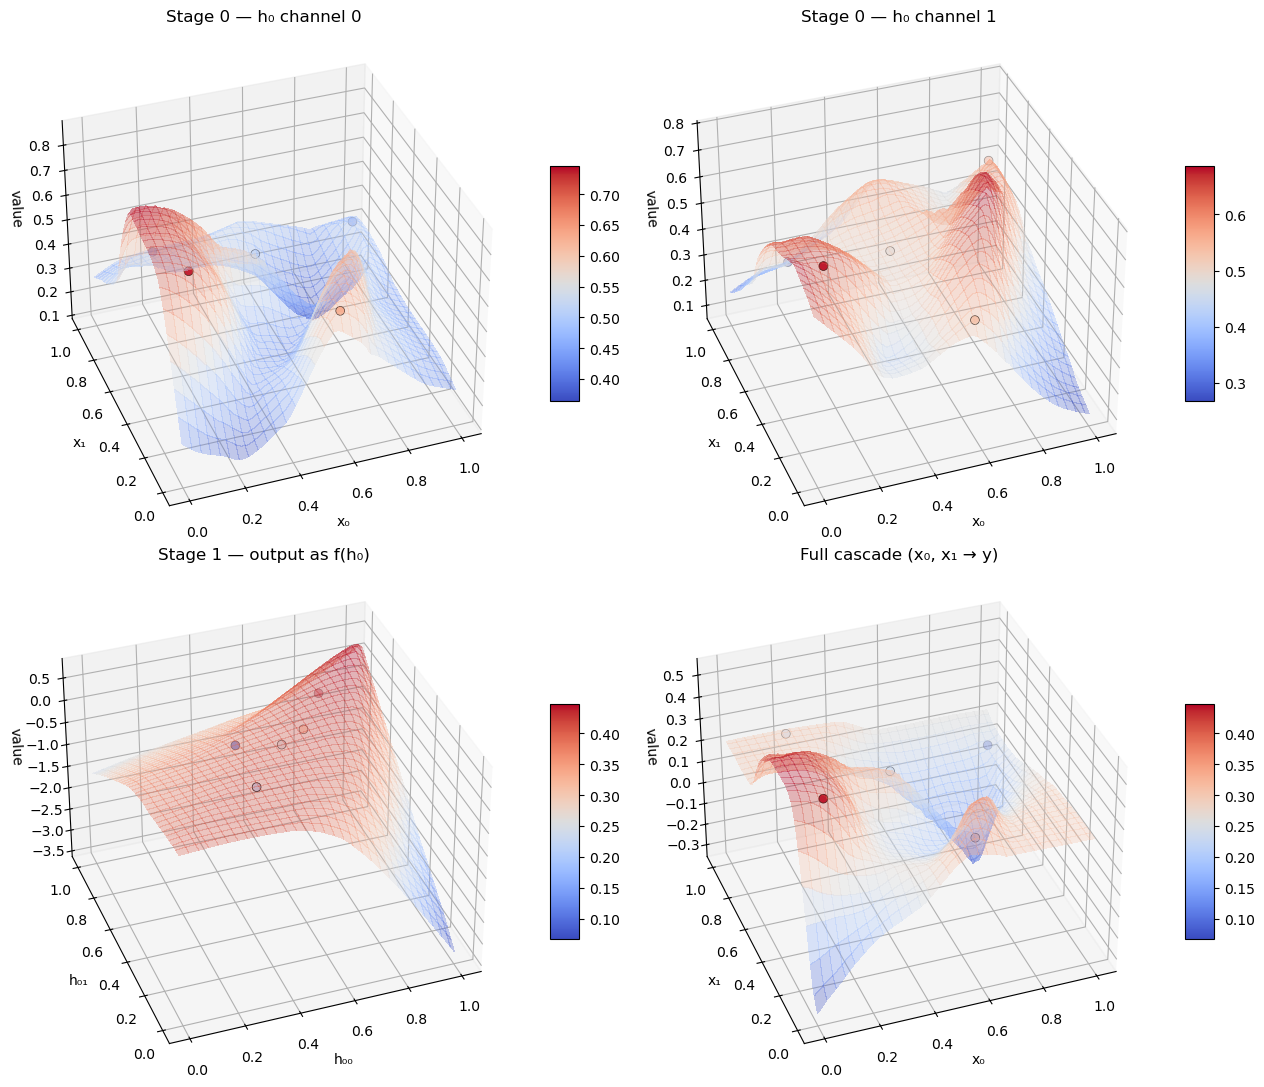

In [5]:
vec_data = lab.get_data()   # returns a vecDict: {stage_id: {'x', 'm'}}
X_samples = vec_data[0]['x']          # stage-0 inputs  (N, 2)
H0_samples = vec_data[0]['m']         # stage-0 measurements, i.e., h0 (N, 2)
Y_samples = vec_data[1]['m'].ravel()  # stage-1 measurements (N,)  — equals h₁ for identity measurement

fig, axes = plt.subplots(2, 2, figsize=(13, 11), subplot_kw={'projection': '3d'})
axes = axes.ravel()

a = np.linspace(0, 1, 60)
y_grid, x_grid = np.meshgrid(a, a)
X_grid = np.stack((x_grid, y_grid), axis=2).reshape(-1, 2)

plots = [
    (stage0_ch0, 'Stage 0 — h₀ channel 0', 'x₀', 'x₁', X_samples, H0_samples[:, :1].ravel()),
    (stage0_ch1, 'Stage 0 — h₀ channel 1', 'x₀', 'x₁', X_samples, H0_samples[:, 1:].ravel()),
    (stage1_only, 'Stage 1 — output as f(h₀)', 'h₀₀', 'h₀₁', H0_samples, Y_samples),
    (final_output, 'Full cascade (x₀, x₁ → y)', 'x₀', 'x₁', X_samples, Y_samples),
]

for ax, (fn, title, xlabel, ylabel, samples_x, samples_y) in zip(axes, plots):
    z = fn(X_grid).reshape(x_grid.shape)
    
    surf = ax.plot_surface(x_grid, y_grid, z, cmap='coolwarm', linewidth=0,
                           antialiased=False, alpha=0.3)
    sc = ax.scatter(samples_x[:, 0], samples_x[:, 1], samples_y,
                    c=samples_y, cmap='coolwarm', s=40, zorder=5, edgecolors='k', linewidth=0.5)
    ax.view_init(elev=35, azim=-110)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel('value')
    ax.set_title(title)
    fig.colorbar(sc, ax=ax, shrink=0.45, aspect=8)

plt.tight_layout()
plt.show()

## 4. Running Individual Experiments
`run_experiment` evaluates one or more input points and stores results in the inventory. Pass stage inputs as a `vecDict`.

In [6]:
# ── change x_new to try a specific point ──────────────────────────────────────
x_new = np.array([[0.25, 0.75]])   # shape (1, 2)

lab.run_experiment(input={0: {'x': x_new}})

print(f"Total samples in inventory: {lab.samples_per_process()[0]}")
lab.inventory_table.tail(3)

Total samples in inventory: 6


process ID                        0  \
                                  x   
sample ID                             
3           [0.12045787, 0.2614422]   
4           [0.21494523, 0.9741822]   
5                      [0.25, 0.75]   

process ID                                             \
                                                    h   
sample ID                                               
3             [0.7454543113708496, 0.685617983341217]   
4            [0.3645237684249878, 0.2685052156448364]   
5           [0.42186397314071655, 0.4434661865234375]   

process ID                                               1  \
                                                    m    x   
sample ID                                                    
3             [0.7454543113708496, 0.685617983341217]   []   
4            [0.3645237684249878, 0.2685052156448364]   []   
5           [0.42186397314071655, 0.4434661865234375]  NaN   

process ID                                                
                                h                      m  
sample ID                                                 
3            [0.4471483528614044]   [0.4471483528614044]  
4           [0.22680924832820892]  [0.22680924832820892]  
5                             NaN                    NaN

## 5. Finding the Global Maximum
`get_maximum` runs a gradient-based optimisation over the process to find the best input.

Optimal input:  [0.0114 0.4039]
Optimal output: 0.516333


/tmp/ipykernel_597299/1370941139.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_opt_ch0 = float(stage0_ch0(x_opt.reshape(1, -1)))
/tmp/ipykernel_597299/1370941139.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_opt_ch1 = float(stage0_ch1(x_opt.reshape(1, -1)))
/tmp/ipykernel_597299/1370941139.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_opt_stage1 = float(stage1_only(h0_opt.reshape(1, -1)))


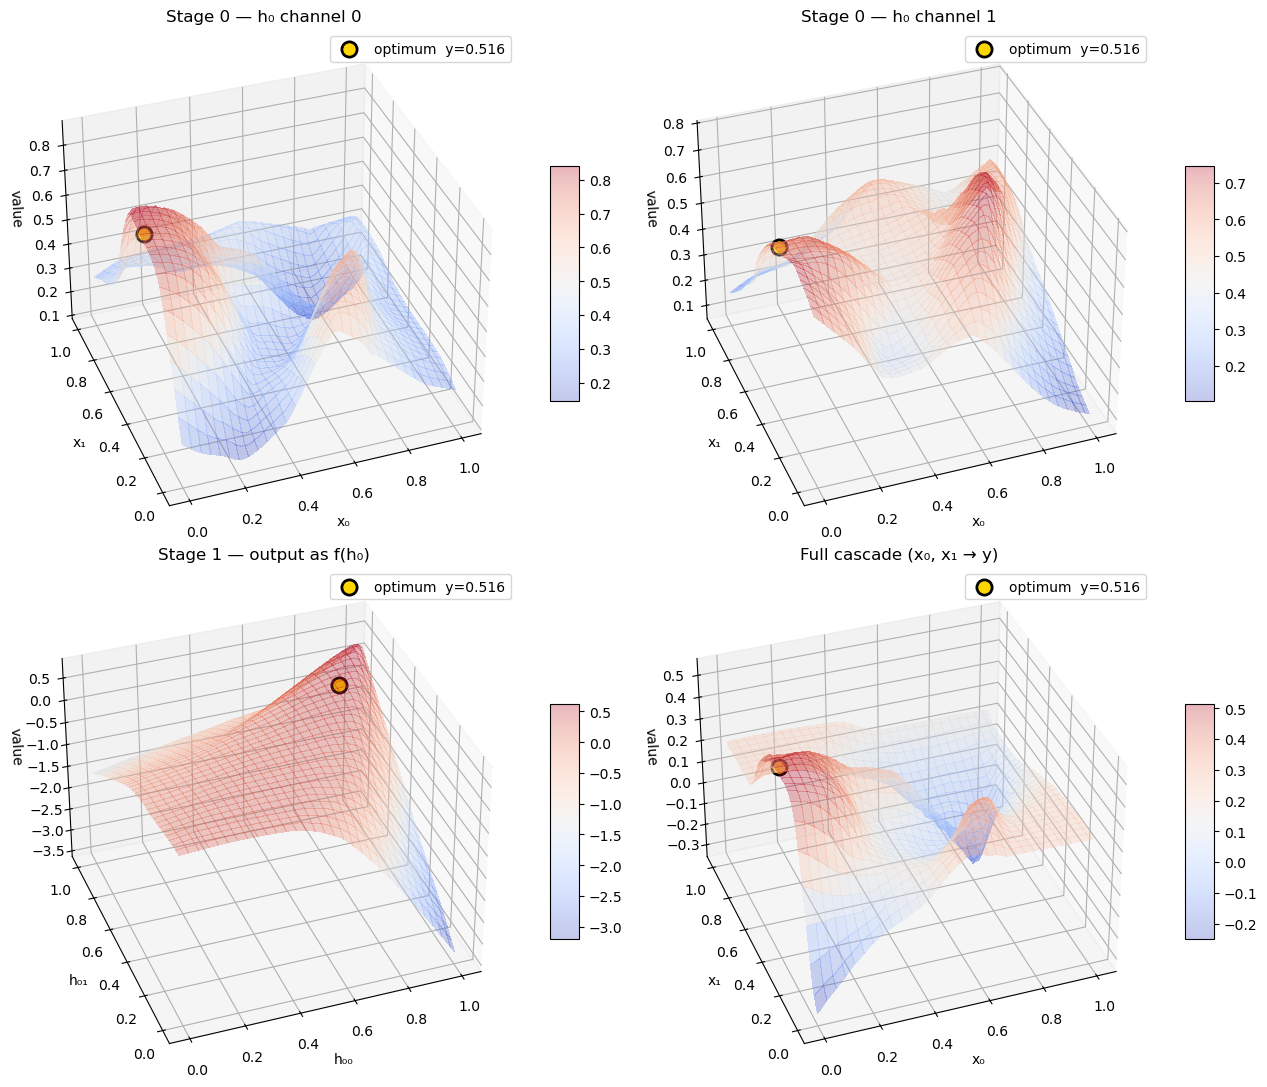

In [8]:
x_opt, y_opt = lab.get_maximum(raw_samples=256, batch_limit=16)
x_opt = np.atleast_1d(x_opt).squeeze()
y_opt = np.atleast_1d(y_opt).squeeze()
print(f"Optimal input:  {x_opt.round(4)}")
print(f"Optimal output: {float(y_opt):.6f}")

# Compute h0 at optimal input
h0_opt, _ = lab.process.call_subprocess(x=x_opt.reshape(1, -1), h=None, idx=0)
h0_opt = h0_opt.squeeze()
z_opt_ch0 = float(stage0_ch0(x_opt.reshape(1, -1)))
z_opt_ch1 = float(stage0_ch1(x_opt.reshape(1, -1)))
z_opt_stage1 = float(stage1_only(h0_opt.reshape(1, -1)))

fig, axes = plt.subplots(2, 2, figsize=(13, 11), subplot_kw={'projection': '3d'})
axes = axes.ravel()

a = np.linspace(0, 1, 60)
y_grid, x_grid = np.meshgrid(a, a)
X_grid = np.stack((x_grid, y_grid), axis=2).reshape(-1, 2)

plots = [
    (stage0_ch0, 'Stage 0 — h₀ channel 0', 'x₀', 'x₁', x_opt, z_opt_ch0),
    (stage0_ch1, 'Stage 0 — h₀ channel 1', 'x₀', 'x₁', x_opt, z_opt_ch1),
    (stage1_only, 'Stage 1 — output as f(h₀)', 'h₀₀', 'h₀₁', h0_opt, z_opt_stage1),
    (final_output, 'Full cascade (x₀, x₁ → y)', 'x₀', 'x₁', x_opt, float(y_opt)),
]

for ax, (fn, title, xlabel, ylabel, opt_point, z_val) in zip(axes, plots):
    z = fn(X_grid).reshape(x_grid.shape)
    
    surf = ax.plot_surface(x_grid, y_grid, z, cmap='coolwarm', alpha=0.3, linewidth=0,
                           antialiased=False)
    ax.scatter(*opt_point[:2], z_val, color='gold', s=120, zorder=10,
               label=f'optimum  y={float(y_opt):.3f}', edgecolors='k', linewidth=2)
    ax.legend()
    ax.view_init(elev=35, azim=-110)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel('value')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.45, aspect=8)

plt.tight_layout()
plt.show()

## 6. Noisy Process
Add Gaussian noise to the hidden state (`noise_process`) and/or the measurement (`noise_meas`), then compare the clean and noisy final outputs.

In [9]:
# ── tune noise levels here ────────────────────────────────────────────────────
PROCESS_NOISE = {0: 0.05, 1: 0.10}   # std added to h per stage
MEAS_NOISE    = {0: 0.02, 1: 0.00}   # std added to measurement m per stage

noisy_config = {
    **config,
    'noise_process': PROCESS_NOISE,
    'noise_meas':    MEAS_NOISE,
}

noisy_lab = Laboratory(noisy_config)

def noisy_output(X):
    n = X.shape[0]
    data = {0: {'x': X}, 1: {'x': np.empty((n, 0))}}
    h_list, _ = noisy_lab.process(data)
    return h_list[-1]

print("Noisy laboratory initialised.")

Noisy laboratory initialised.


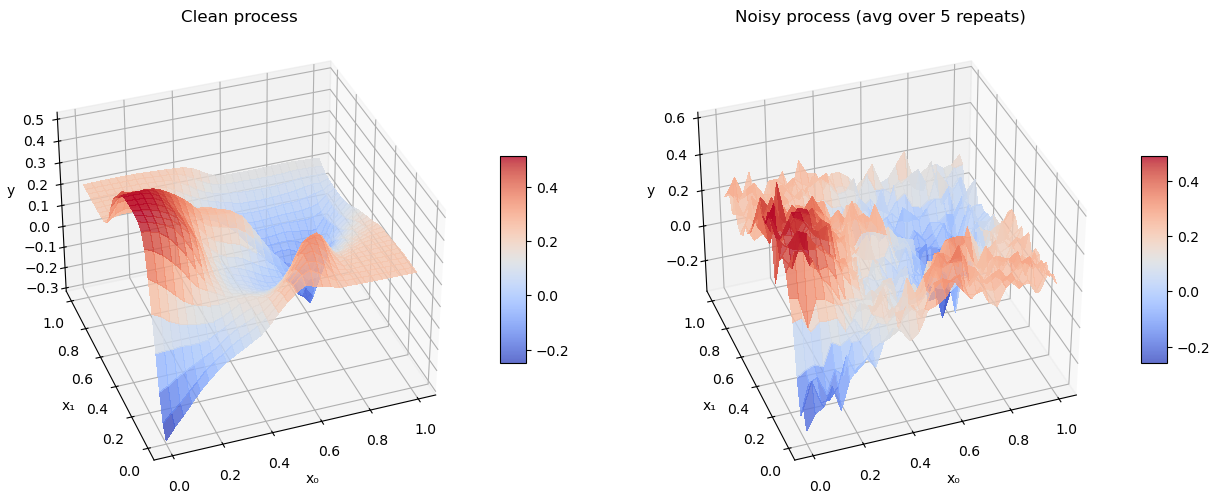

In [10]:
N_REPEAT = 5   # ← number of repeated evaluations at each grid point

# Build a coarser grid for speed
a_c = np.linspace(0, 1, 30)
y_c, x_c = np.meshgrid(a_c, a_c)
X_coarse = np.stack((x_c, y_c), axis=2).reshape(-1, 2)

z_clean = final_output(X_coarse).reshape(x_c.shape)
z_noisy = np.mean(
    np.stack([noisy_output(X_coarse).reshape(x_c.shape) for _ in range(N_REPEAT)], axis=0),
    axis=0,
)

fig, axes = plt.subplots(1, 2, figsize=(13, 5), subplot_kw={'projection': '3d'})
for ax, z, title in zip(axes,
                         [z_clean, z_noisy],
                         ['Clean process', f'Noisy process (avg over {N_REPEAT} repeats)']):
    surf = ax.plot_surface(x_c, y_c, z, cmap='coolwarm', linewidth=0,
                           antialiased=False, alpha=0.8)
    ax.view_init(elev=35, azim=-110)
    ax.set_xlabel('x₀'); ax.set_ylabel('x₁'); ax.set_zlabel('y')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.45, aspect=8)

plt.tight_layout()
plt.show()

## 7. Multi-Stage Measurement Filter
Using `('filter', k)` for the measurement of stage 0 limits how many channels of `h₀` are passed as observations — demonstrating partial observability between stages.

In [11]:
# Stage 0 produces a 2-D hidden state but only 1 channel is observed (m₀)
filtered_config = {
    **config,
    'measurement': {0: ('filter', 1),      # only first channel of h₀ is observable
                    1: ('identity', None)},
}

flab = Laboratory(filtered_config)
flab.randomized_sampling(n_samples=N_INIT)

vec = flab.get_data()
# get_data returns measurements (m), not hidden states (h)
print("Stage-0 measurement  m₀ shape:",   vec[0]['m'].shape)   # (N, 1) — filtered (only 1 of 2 h₀ channels)
print("Stage-1 measurement  m₁ shape:",   vec[1]['m'].shape)   # (N, 1) — identity measurement

Stage-0 measurement  m₀ shape: (5, 1)
Stage-1 measurement  m₁ shape: (5, 1)


## 8. Quick Reference — Laboratory API

| Method | Description |
|---|---|
| `lab.randomized_sampling(n, method)` | Draw `n` Sobol / uniform samples and store in inventory |
| `lab.run_experiment(input, sample_id)` | Run one experiment (optionally extend an existing sample) |
| `lab.get_data(sample_ids, process_ids)` | Retrieve stored data as a `vecDict` |
| `lab.store_data(vecDict)` | Write an external `vecDict` to the inventory |
| `lab.inventory_table` | `pd.DataFrame` view of the full inventory |
| `lab.samples_per_process()` | List of sample-ID lists per stage |
| `lab.get_maximum()` | Gradient-based global optimum search |